In [0]:
from google.colab import files

uploaded = files.upload()

Saving westphilly_test12.tif to westphilly_test12.tif


# Using Google Drive in Google Colab

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


# Cloning the Dataset

In [0]:
!git clone https://github.com/prizopedro/CIS545.git

Cloning into 'CIS545'...
remote: Counting objects: 2192, done.
remote: Compressing objects: 100% (1590/1590), done.
remote: Total 2192 (delta 599), reused 2191 (delta 598), pack-reused 0
Receiving objects: 100% (2192/2192), 369.83 MiB | 36.56 MiB/s, done.
Resolving deltas: 100% (599/599), done.
Checking out files: 100% (2167/2167), done.


In [0]:
ls

aerial_data/


In [0]:
cd CIS5

/content/CIS545


# Libraries Used 

In [0]:
import numpy as np
import scipy 

from keras.models import *
from keras.layers import Input, merge, Conv1D,Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

Using TensorFlow backend.


# Functions for Loading the Dataset (Training and Testing)

In [0]:
def X_train_load(size):
  city = ['austin','chicago','kitsap','tyrol-w','vienna']
  starting = True
  A = scipy.misc.imread('aerial_data/small/train_image/austin1_0.tif')
    
  for c in range(5):
    for i in range(1,size):
      for j in range(4):
        if starting == True:
          starting = False
          continue
        #s = str(i) + '.tif'
        s = 'aerial_data/small/train_image/'+ city[c] + str(i) + '_' + str(j) + '.tif'
        B = scipy.misc.imread(s)
        #print(s, B.shape)
        A  = np.dstack([A, B])
      

  return A.T

def Y_train_load(size):
  city = ['austin','chicago','kitsap','tyrol-w','vienna']
  starting = True
  A = scipy.misc.imread('aerial_data/small/train_label/austin1_0_L.tif')
  for c in range(5):
    for i in range(1,size):
      for j in range(4):
        if starting == True:
          starting = False
          continue
        #s = str(i) + '_L.tif'
        s = 'aerial_data/small/train_label/'+city[c] + str(i) + '_' + str(j) + '_L.tif'
        B = scipy.misc.imread(s)
        A  = np.dstack([A, B])

  return A.T

def X_test_load(size):
  city = ['bellingham']
  starting = True
  A = scipy.misc.imread('bellingham1_0.tif')
  for c in range(1):
    for i in range(1,size):
      for j in range(4):
        if starting == True:
          starting = False
          continue
        #s = str(i) + '_T.tif'
        s = city[c] + str(i) + '_' + str(j) + '.tif'
        B = scipy.misc.imread(s)
        A  = np.dstack([A, B])

  return A.T


# Loading All the Data

In [0]:
X_train = X_train_load(size=37)
Y_train = Y_train_load(size=37)
#X_test = X_test_load(size=5)

X_train = X_train.reshape(*X_train.shape,1)
Y_train = Y_train.reshape(*Y_train.shape,1)
#X_test = X_test.reshape(*X_test.shape,1)


X_train = X_train.astype('float32')
Y_train = Y_train.astype('float32')
#X_test = X_test.astype('float32')

X_train/= 255
Y_train/= 255
#X_test/= 255

Y_train[Y_train > 0.5] = 1
Y_train[Y_train <= 0.5] = 0

In [0]:
#X_train = X_train_load(size=37)
print(X_train.shape)

(720, 512, 512, 1)


# Loading an Image from Google Earth

In [0]:
#X_test = X_test_load(size=2)
X_test = np.expand_dims(scipy.misc.imread('westphilly_test12.tif').T,axis=0)


print(X_test.shape)
X_test = X_test.reshape(*X_test.shape,1)
X_test = X_test.astype('float32')
X_test/= 255

(1, 512, 512)


# U-Net Architecture

In [0]:
def unet(X_train, Y_train):

  inputs = Input(shape=(512, 512,1))

  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  print("conv1 shape:",conv1.shape)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  print("conv1 shape:",conv1.shape)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  print("pool1 shape:",pool1.shape)

  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  print("conv2 shape:",conv2.shape)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  print("conv2 shape:",conv2.shape)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  print("pool2 shape:",pool2.shape)

  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  print("conv3 shape:",conv3.shape)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  print("conv3 shape:",conv3.shape)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  print("pool3 shape:",pool3.shape)

  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  print("conv4 shape:",conv4.shape)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  print("conv4 shape:",conv4.shape)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
  print("pool4 shape:",pool4.shape)


  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  print("conv5 shape:",conv5.shape)
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  print("conv5 shape:",conv5.shape)
  drop5 = Dropout(0.5)(conv5)

  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  print("up6:",up6.shape)
  merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)


  model = Model(input = inputs, output = conv10)

  model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

  model.fit(X_train, Y_train,                # Train the model using the training set...
            batch_size=4, epochs=10,
            verbose=1, validation_split=0.1,shuffle=True) # ...holding out 10% of the data for validation

  return model


In [0]:
model = unet(X_train, Y_train)

conv1 shape: (?, 512, 512, 64)
conv1 shape: (?, 512, 512, 64)
pool1 shape: (?, 256, 256, 64)
conv2 shape: (?, 256, 256, 128)
conv2 shape: (?, 256, 256, 128)
pool2 shape: (?, 128, 128, 128)
conv3 shape: (?, 128, 128, 256)
conv3 shape: (?, 128, 128, 256)
pool3 shape: (?, 64, 64, 256)
conv4 shape: (?, 64, 64, 512)
conv4 shape: (?, 64, 64, 512)
pool4 shape: (?, 32, 32, 512)
conv5 shape: (?, 32, 32, 1024)
conv5 shape: (?, 32, 32, 1024)
up6: (?, 64, 64, 512)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python3.6/dist-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: The `m

Train on 648 samples, validate on 72 samples
Epoch 1/10
648/648 [==============================] - 603s 931ms/step - loss: 0.4922 - acc: 0.8494 - val_loss: 0.5976 - val_acc: 0.7383
Epoch 2/10
648/648 [==============================] - 590s 911ms/step - loss: 0.3873 - acc: 0.8592 - val_loss: 0.4586 - val_acc: 0.7950
Epoch 3/10
320/648 [=============>................] - ETA: 4:47 - loss: 0.2992 - acc: 0.8812648/648 [==============================] - 591s 912ms/step - loss: 0.3062 - acc: 0.8780 - val_loss: 0.4330 - val_acc: 0.8048
Epoch 4/10
648/648 [==============================] - 592s 913ms/step - loss: 0.2765 - acc: 0.8877 - val_loss: 0.4260 - val_acc: 0.8061
Epoch 5/10
648/648 [==============================] - 592s 913ms/step - loss: 0.2586 - acc: 0.8942 - val_loss: 0.4037 - val_acc: 0.8195
Epoch 6/10
648/648 [==============================] - 592s 914ms/step - loss: 0.2454 - acc: 0.9000 - val_loss: 0.4219 - val_acc: 0.8165
Epoch 7/10
648/648 [==============================] - 592s

# Saving the Model

In [0]:
from keras.models import load_model

# Creates a HDF5 file 'my_model.h5'
model.save('aerial_model.h5')

# Deletes the existing model
#del model  

# Returns a compiled model identical to the previous one
model = load_model('aerial_model.h5')

# Saving the Model on Google Drive

In [0]:
# Create & upload a file.

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


uploaded = drive.CreateFile({'Weights': 'aerial_model.h5'})
uploaded.SetContentFile('aerial_model.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))
# ssh git@gitlab.com

Uploaded file with ID 1wWD7MlSi_Ak7CFDuhAaBHadl_V0SHeti


# Using the Model to predict

In [0]:
Y_test = model.predict(X_test, verbose=1)

1/1 [==============================] - 0s 417ms/step


# Function for Plotting

In [0]:
def op(X_test,Y_test,size):
  for i in range(0,size):
    a = Y_test[i].copy()
    c = a.flatten().reshape(512,512).T
    plt.figure()
    plt.imshow(c);
    plt.colorbar()
    plt.show()
    
    
    c_bar = X_test[i].reshape(512,512).T
    plt.figure()
    plt.imshow(c_bar);
    plt.colorbar()
    plt.show()


# Plotting the Segmentation

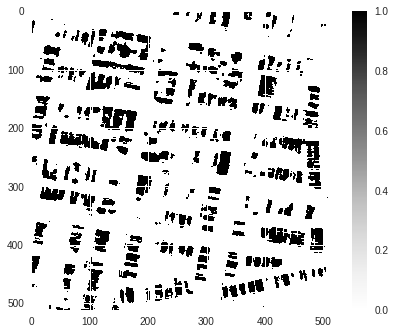

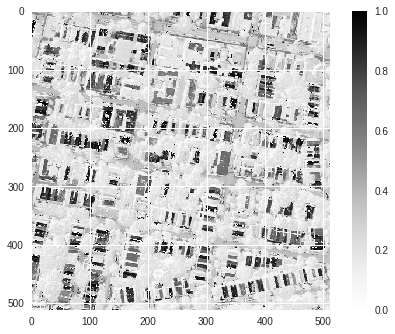

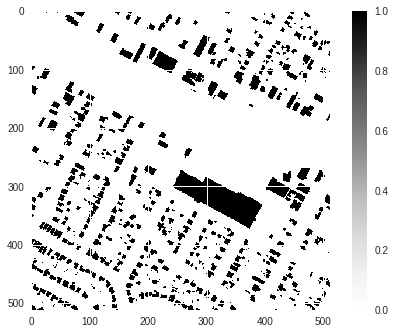

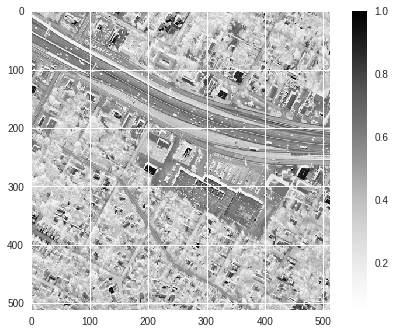

In [0]:
import matplotlib.pyplot as plt


op(X_test,Y_test,1)

op(X_train,Y_train,1)

In [0]:
Y_test[Y_test > 0.3] = 1
Y_test[Y_test <= 0.3] = 0

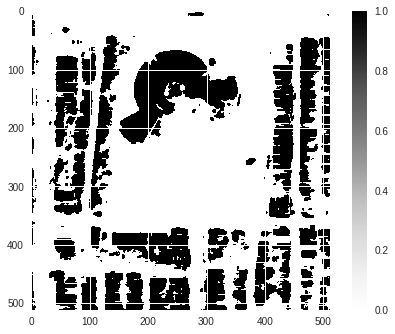

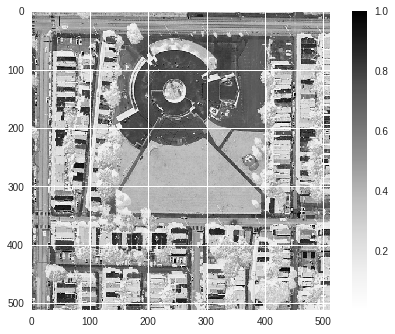

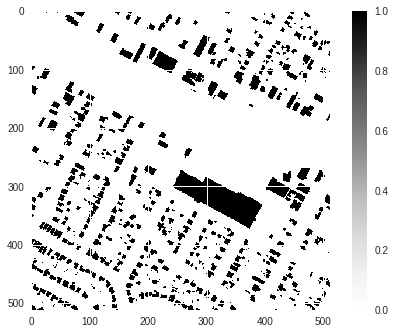

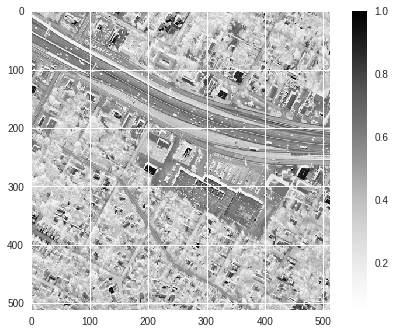

In [0]:
op(X_test,Y_test,1)

op(X_train,Y_train,1)

# Plotting Accuracy Curves and Loss Curves

In [0]:
loss = [0.4922,0.3873,0.2992,0.2765,0.2586,0.2454,0.2339,0.2249,0.2132,0.2037]

acc = [0.8494, 0.8592, 0.8812, 0.8877, 0.8942, 0.9000,0.9040,0.9088,0.9128,0.9166]

val_loss = [0.5976,0.4586,0.4330,0.4260,0.4037,0.4219,0.3850,0.4197,0.3706,0.3568]

val_acc = [0.7383,0.7950,0.8048,0.8061,0.8195,0.8165,0.8307,0.8193,0.8351,0.8448]

epoch = range(1,11)

import matplotlib.pyplot as plt

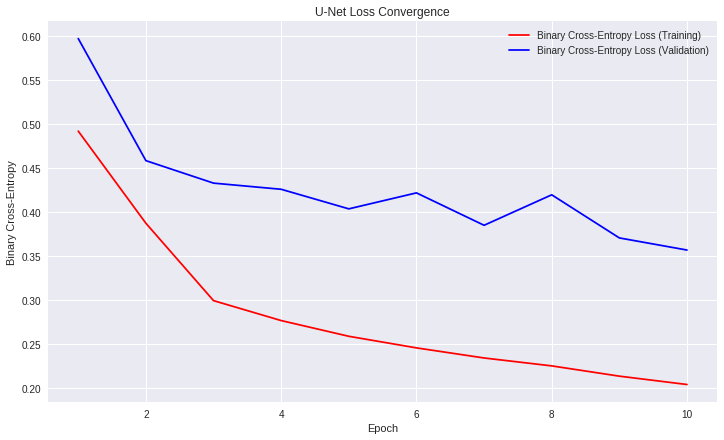

In [4]:
plt.figure(figsize=(12,7))
plt.plot(epoch, loss,'r',label='Binary Cross-Entropy Loss (Training)')
plt.plot(epoch, val_loss,'b',label='Binary Cross-Entropy Loss (Validation)')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy')
plt.title('U-Net Loss Convergence')
plt.legend()
plt.show()

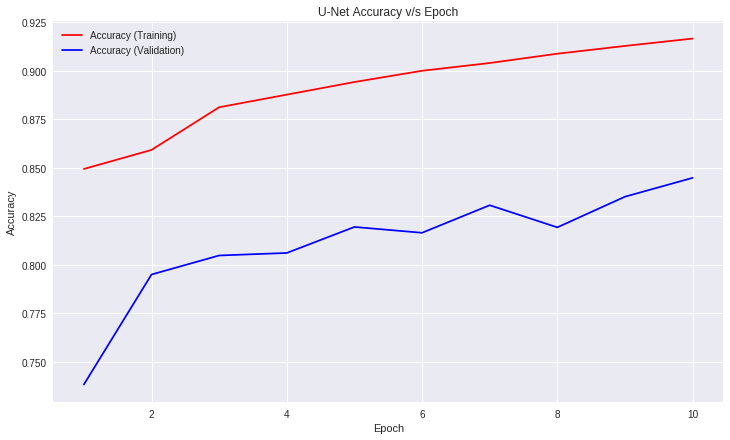

In [5]:
plt.figure(figsize=(12,7))
plt.plot(epoch, acc,'r',label='Accuracy (Training)')
plt.plot(epoch, val_acc,'b',label='Accuracy (Validation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('U-Net Accuracy v/s Epoch')
plt.legend()
plt.show()